In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np
import pandas as pd
import sqlalchemy as sqa
import matplotlib.pyplot as plt
from datetime import date, timedelta

from functools import reduce
from tqdm.auto import tqdm

import mechafil.data as d
import mechafil.data_spacescope as dss


In [30]:
sso = dss.SpacescopeDataConnection('/Users/kiran/code/auth/kiran_spacescope_auth.json')

In [31]:
# Define some constants for future use
# Define the height of the blockchain from which the data should be taken
HEIGHT=2_800_000
# Define the actor which we want to investigate
ACTOR='storagemarket'
# Define the time at which the Filecoin network was launched (in Unix epoch time)
FILECOIN_GENESIS_UNIX_EPOCH = 1598306400

In [32]:
# Open the secret file which contains connection string to the database
with open('/Users/kiran/code/auth/lily.txt') as f:
    secretString = f.read()
    
# Try to create a connection to the database
try:
    # Define an engine using the connection string
    engine = sqa.create_engine(secretString)
    # Establish a connection to the database
    conn = engine.connect()
# If the connection fails, catch the exception and print an error message
except Exception as e:
    print("Failed to connect to database")
    # Propagate the error further
    raise(e)

Failed to connect to database


OperationalError: (psycopg2.OperationalError) connection to server at "sentinel-production-protocol-5870.a.timescaledb.io" (34.228.41.113), port 13573 failed: FATAL:  role "readonly" is not permitted to log in

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [6]:
# Define SQL query to get gas used by the storage market actor on each epoch. 
QUERY_1 = f'''
     SELECT height, SUM(gas_used) 
     FROM "visor"."derived_gas_outputs"
     WHERE height > {HEIGHT} AND actor_family='{ACTOR}'
     GROUP BY height
     ORDER BY height ASC
 '''

# Define SQL query to get the QAP (Quality-Adjusted Power), in bytes, per epoch
QUERY_2= f'''
      SELECT height, total_qa_bytes_committed, total_raw_bytes_committed
      FROM "visor"."chain_powers"
      WHERE height > {HEIGHT} 
      ORDER BY height ASC
  '''

# Execute the queries and store the results in pandas DataFrames
df1 = pd.read_sql(sql=sqa.text(QUERY_1), con=conn)
df2 = pd.read_sql(sql=sqa.text(QUERY_2), con=conn)

In [7]:
# Merge the two dataframes on 'height' column
df = pd.merge(df1, df2, on='height')

# Convert total_qa_bytes_committed from bytes to PiB (Pebibytes)
df['total_qa_bytes_committed'] = df['total_qa_bytes_committed'] / (2**50)
df['total_raw_bytes_committed'] = df['total_raw_bytes_committed'] / (2**50)
# Create a new column that calculates the difference between each row and the previous one in 'total_qa_bytes_committed'
df['diff_qa'] = df['total_qa_bytes_committed'].diff()
df['diff_rb'] = df['total_raw_bytes_committed'].diff()
df['onboarded_filp_data'] = (df['diff_qa'] - df['diff_rb'])/9.0
df['onboarded_cc_data'] = df['diff_rb'] - df['onboarded_filp_data']

# Create a new column 'time' by converting the blockchain height to datetime format
df['time'] = pd.to_datetime(df['height'].values*30 + FILECOIN_GENESIS_UNIX_EPOCH, unit='s')
# Remove rows with missing values
df = df.dropna()

<IPython.core.display.Javascript object>


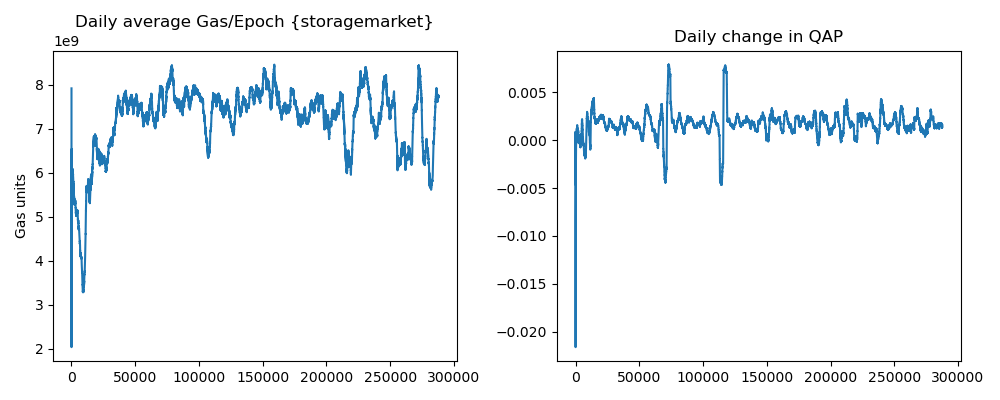

In [8]:
# Define the time window over which the averages should be calculated
WINDOW='24H'
# Calculate the rolling averages over the defined time window
rolling_gas = df.rolling(WINDOW, on='time')['sum'].mean()
rolling_onboarded_QAP = df.rolling(WINDOW, on='time')['onboarded_filp_data'].mean()

# Plot the rolling averages of gas used and QAP onboarded
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(rolling_gas)
plt.title('Daily average Gas/Epoch {storagemarket}')
plt.ylabel('Gas units')

plt.subplot(122)
plt.plot(rolling_onboarded_QAP)
plt.title('Daily change in QAP')

plt.tight_layout()

<IPython.core.display.Javascript object>


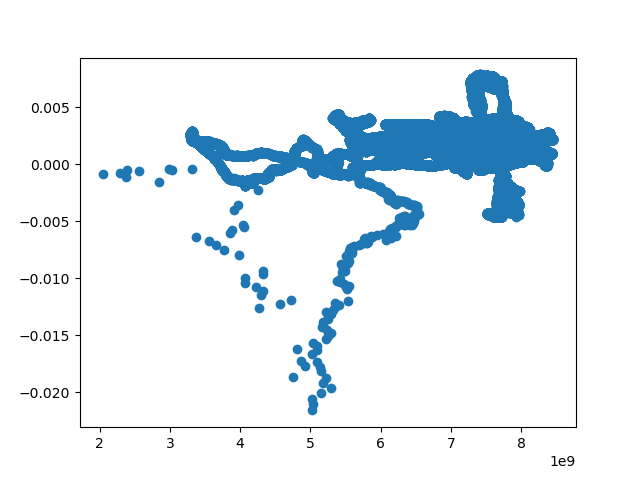

In [9]:
plt.figure()
plt.scatter(rolling_gas, rolling_onboarded_QAP)

In [ ]:
# def query_gasused(actor):
#     sql_query_str = f'''
#          SELECT height, SUM(gas_used) 
#          FROM "visor"."derived_gas_outputs"
#          WHERE height > {HEIGHT} AND actor_family='{actor}'
#          GROUP BY height
#          ORDER BY height ASC
#      '''
#     # Execute the queries and store the results in pandas DataFrames
#     df = pd.read_sql(sql=sqa.text(sql_query_str), con=conn)
#     return df

In [ ]:
# # get gas used by all actors, then see if the total adds up to daily_burnt_fil from starboard
# actor_list = ['storagemarket', 'fevm', 'reward', 'power', 'multisig', 'storageminer', 'init']
# dfs = {}
# for a in tqdm(actor_list):
#     df = query_gasused(actor=a)
#     dfs[a] = df

In [ ]:
# len(dfs['storagemarket']), len(dfs['storageminer'])

In [ ]:
# # dfs['storagemarket'].join(dfs['storageminer'], on='height', how='outer', 
# #                           lsuffix='_storagemarket', rsuffix='_storageminer')
# pd.merge(dfs['storagemarket'], dfs['storageminer'], on='height', how='outer')

In [ ]:
# for ii in range(len(actor_list)-1):
#     df_b = dfs[actor_list[ii]]
#     df_b = df_b.rename(columns={'sum': 'sum_%s' % (actor_list[ii],)})
#     if ii == 0:
#         df_a = dfs[actor_list[ii-1]]
#         df_a = df_a.rename(columns={'sum': 'sum_%s' % (actor_list[ii-1],)})
#     else:
#         df_a = merged_df
# #     if len(df_a) > 0 and len(df_b) > 0:
#     merged_df = pd.merge(df_a, df_b, on='height', how='outer')

In [ ]:
# merged_df['datetime'] = pd.to_datetime(merged_df['height'].values*30 + FILECOIN_GENESIS_UNIX_EPOCH, unit='s')
# merged_df = merged_df.sort_values('datetime')

# sum_cols = [c for c in merged_df.columns if 'sum' in c]
# merged_df['total_gas'] = merged_df[sum_cols].sum(axis=1, skipna=True)

In [ ]:
# gas_daily_lily = merged_df.groupby(merged_df['datetime'].dt.date)['total_gas'].sum()

In [12]:
gas_daily_lily = df.groupby(df['time'].dt.date)['sum'].sum()

In [16]:
start_date = pd.to_datetime(df.iloc[0]['time']).date()
end_date = pd.to_datetime(df.iloc[-1]['time']).date()
current_date = date(end_date.year, end_date.month-1, 1)
d.setup_spacescope('/Users/kiran/code/auth/kiran_spacescope_auth.json')
fil_stats_df = d.get_historical_network_stats(start_date, end_date, end_date)

In [17]:
df_gas = sso.spacescope_query(
    start_date,
    end_date,
    url_template='https://api.spacescope.io/v2/gas/daily_gas_usage_in_units?end_date=%s&start_date=%s'
)

<IPython.core.display.Javascript object>


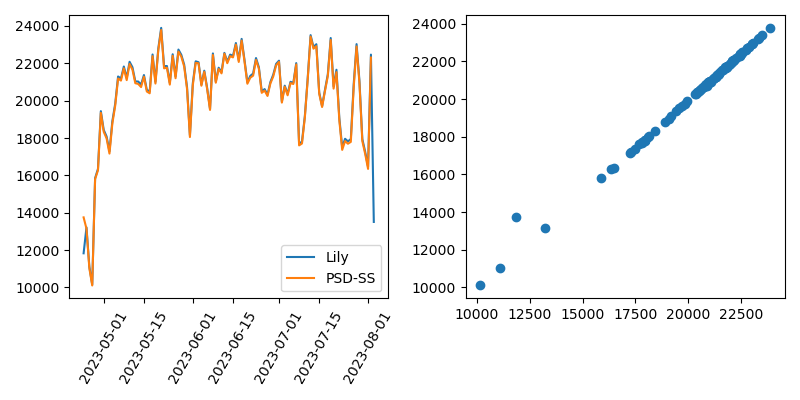

In [27]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
# plt.plot(fil_stats_df['date'], fil_stats_df['burnt_fil'].diff(), label='Spacescope')
plt.plot(gas_daily_lily.index, gas_daily_lily*1e-9, label='Lily')
plt.plot(pd.to_datetime(df_gas['stat_date']).dt.date, df_gas['publish_storage_deals_gas_used']*1e-9, label='PSD-SS')

plt.xticks(rotation=60)
plt.legend()

plt.subplot(1,2,2)
plt.scatter(gas_daily_lily.iloc[0:-1]*1e-9, df_gas['publish_storage_deals_gas_used']*1e-9)

plt.tight_layout()

In [ ]:
df_gas